In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import cv2
import numpy as np
import torch
import torchvision
from pytorch_grad_cam import AblationCAM, EigenCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels, scale_cam_image

In [3]:


def predict(input_tensor, model, device, detection_threshold):
    outputs = model(input_tensor)
    pred_classes = [coco_names[i] for i in outputs[0]['labels'].cpu().numpy()]
    pred_labels = outputs[0]['labels'].cpu().numpy()
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    
    boxes, classes, labels, indices = [], [], [], []
    for index in range(len(pred_scores)):
        if pred_scores[index] >= detection_threshold:
            boxes.append(pred_bboxes[index].astype(np.int32))
            classes.append(pred_classes[index])
            labels.append(pred_labels[index])
            indices.append(index)
    boxes = np.int32(boxes)
    return boxes, classes, labels, indices

def draw_boxes(boxes, labels, classes, image):
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1] - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return image

coco_names = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', \
              'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 
              'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 
              'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella',
              'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
              'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
              'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork',
              'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
              'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
              'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet',
              'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
              'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase',
              'scissors', 'teddy bear', 'hair drier', 'toothbrush']


# This will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))



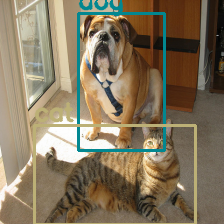

In [4]:
import requests
import torchvision
from PIL import Image
image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
image = np.array(Image.open(requests.get(image_url, stream=True).raw))
image_float_np = np.float32(image) / 255
# define the torchvision image transforms
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

input_tensor = transform(image)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)
# Add a batch dimension:
input_tensor = input_tensor.unsqueeze(0)

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval().to(device)

# Run the model and display the detections
boxes, classes, labels, indices = predict(input_tensor, model, device, 0.9)
image = draw_boxes(boxes, labels, classes, image)

# Show the image:
Image.fromarray(image)


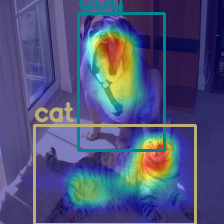

In [5]:
target_layers = [model.backbone]
targets = [FasterRCNNBoxScoreTarget(labels=labels, bounding_boxes=boxes)]
cam = EigenCAM(model,
               target_layers, 
               use_cuda=torch.cuda.is_available(),
               reshape_transform=fasterrcnn_reshape_transform)

grayscale_cam = cam(input_tensor, targets=targets)
# Take the first image in the batch:
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)
# And lets draw the boxes again:
image_with_bounding_boxes = draw_boxes(boxes, labels, classes, cam_image)
Image.fromarray(image_with_bounding_boxes)